In [4]:
! pip install python-dotenv --user

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [5]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
from custom.functions import InvokeWMLModel
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator
from custom import settings
import datetime as dt

import pandas as pd
import numpy as np

from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import sklearn
import time

import os
import json

/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/iotfunctions/bif.py:1995: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'

2020-06-01 11:33:12,177 - root - INFO - 
Logging Set To: DEBUG


Loading WML Environment Variables
Environment Variables Loaded Successfully


In [6]:
# Load .env file
from dotenv import load_dotenv
env_path = 'custom/.env'
load_dotenv(dotenv_path=env_path)

True

In [34]:
# USER PREREQ #
# Set path to Monitor credentials file in .env
if 'MONITOR_CREDENTIALS_PATH' in os.environ.keys():
    creds_file = os.environ['MONITOR_CREDENTIALS_PATH']
else:
    creds_file = "./credentials/monitor-demo-creds.json"
    
with open(creds_file, 'r') as f: 
    credentials = json.loads(f.read())

db = Database(credentials = credentials)
db_schema = None #  set if you are not using the default

# USER PREREQ #
# Set the entity name you'd like to retrieve data from
if 'ENTITY_NAME' in os.environ.keys():
    entity_name = os.environ["ENTITY_NAME"]
else:
    entity_name = "Equipment"

df = db.read_table(table_name=entity_name, schema=db_schema)



2020-06-01 11:48:21,734 - iotfunctions.db - INFO - 
Connection string for SqlAlchemy => db2): db2+ibm_db://iotanalytics:I0TAnalytics2@2@@dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:50000/BLUDB;

2020-06-01 11:48:21,734 - iotfunctions.db - INFO - 
Connection string for SqlAlchemy => db2): db2+ibm_db://iotanalytics:I0TAnalytics2@2@@dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:50000/BLUDB;

2020-06-01 11:48:21,763 - iotfunctions.db - DEBUG - 
created a CosClient object

2020-06-01 11:48:22,496 - iotfunctions.db - DEBUG - 
Db connection established

2020-06-01 11:48:24,044 - iotfunctions.db - DEBUG - 
http request successful. status 200
/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sqlalchemy/engine/reflection.py:919: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'turbine_demo'
  "columns for table '%s'" % (flavor, c, table_name)


# Train Model

In [26]:
## TRAIN MODEL
## Build custom model locally (user custom data science notebook will go here)

# USER PREREQ #
# Define input columns (Replace with your asset columns here)
s = lambda x: x.strip()
if 'INPUT_COLUMNS' in os.environ.keys():
    columns = list(map(s, os.environ['INPUT_COLUMNS'].split(',')))
else:
    columns = ['drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2', 'drvn_flow']

columns.sort()

# USER PREREQ #
# Define entity IDs. For the best performance, add ids of entities that exhibit anomalous behavior
if 'ENTITY_IDS' in os.environ.keys():
    entities = list(map(s, os.environ['ENTITY_IDS'].split(',')))
else:
    entities = ["73000", "73001"]

# Filter dataframe to selected entities / input columns
s_df = pd.DataFrame(columns=columns)
for e in entities:
    selected_entity_data = df[columns].loc[ df['deviceid'] == int(e), :][columns]
    s_df = s_df.append( selected_entity_data, ignore_index=True)

# Convert dataframe to 2d Array (WML needs array for sending JSON)
rows = [list(r) for i,r in s_df.iterrows()]
# Create a model (using IsolationForest here with default settings)
clf = IsolationForest()
# Place classifier in a sklearn "pipeline"
pipeline = Pipeline( steps = [ ( "classifier", clf ) ] )
# Fit data to model pipeline
pipeline.fit(rows)
# Test model
results = pipeline.predict(rows)
# Store model results into 'anomaly_score' column
s_df.loc[: ,'anomaly_score'] = results
print(s_df.head())

     drvn_flow    drvn_p1    drvn_p2    drvn_t1     drvn_t2  anomaly_score
0  2519.746213  55.648417  71.804410  71.804410  150.789260              1
1  2519.746213  55.648417  71.804410  71.804410  150.789260              1
2  2518.701244  52.703506  68.004524  68.004524  142.809500              1
3  2516.083597  45.326501  58.485807  58.485807  122.820195              1
4  1105.073515  17.001131  17.001131  68.004524   68.004524              1


/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [27]:
# Print breakdown of anomalous values vs non-anomalous
from collections import Counter
print(Counter(results))

Counter({1: 2109, -1: 235})



2020-06-01 13:48:55,862 - matplotlib.font_manager - DEBUG - 
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.

2020-06-01 13:48:55,863 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:55,864 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05

2020-06-01 13:48:55,865 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335

2020-06-01 13:48:55,865 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:55,866 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335

2020-06-01 13:48:55,867 - matplotlib.font_ma


2020-06-01 13:48:55,915 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:55,917 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:55,919 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 700 normal>) = 10.335

2020-06-01 13:48:55,920 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Condensed' (IBMPlexSansCondensed-ExtraLightItalic.ttf) italic normal light condensed>) = 11.44

2020-06-01 13:48:55,921 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:55,922 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Arabic' (IBMPlexArabic-Bold.ttf) normal normal bold normal>) = 10.335

2


2020-06-01 13:48:55,981 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Devanagari' (IBMPlexDevanagari-Regular.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:55,982 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:55,984 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:55,985 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-ExtraLightItalic.ttf) italic normal light normal>) = 11.24

2020-06-01 13:48:55,987 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:55,988 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF Compact Text' (SFCompactTextItalic.ttf) italic normal 400 


2020-06-01 13:48:56,048 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,050 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05

2020-06-01 13:48:56,051 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,052 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,053 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,054 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335

2020-06-01 13:48:56,055 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Thai Lo


2020-06-01 13:48:56,108 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Devanagari' (IBMPlexDevanagari-Thin.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,109 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,110 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,111 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Thai Looped' (IBMPlexSansThaiLooped-Text.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,112 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal regular normal>) = 11.05

2020-06-01 13:48:56,113 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,114 - matplotlib.font_manager - DE


2020-06-01 13:48:56,170 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal regular normal>) = 10.05

2020-06-01 13:48:56,171 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05

2020-06-01 13:48:56,172 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:56,173 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,174 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 6.698636363636363

2020-06-01 13:48:56,175 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,176 - matplotlib.font_mana


2020-06-01 13:48:56,223 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-TextItalic.ttf) italic normal 400 normal>) = 11.05

2020-06-01 13:48:56,224 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999

2020-06-01 13:48:56,226 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-ExtraLightItalic.ttf) italic normal light normal>) = 11.24

2020-06-01 13:48:56,229 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:56,230 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-Regular.ttf) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,232 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10


2020-06-01 13:48:56,334 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,335 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725

2020-06-01 13:48:56,336 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,336 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,337 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-SemiBoldItalic.ttf) italic normal semibold normal>) = 11.24

2020-06-01 13:48:56,338 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:


2020-06-01 13:48:56,378 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Condensed' (IBMPlexSansCondensed-ThinItalic.ttf) italic normal 400 condensed>) = 11.25

2020-06-01 13:48:56,379 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:56,380 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 4.6863636363636365

2020-06-01 13:48:56,382 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05

2020-06-01 13:48:56,382 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-Light.ttf) normal normal light normal>) = 10.24

2020-06-01 13:48:56,383 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Hebrew' (IBMPlexSansHebrew-SemiBold.ttf) normal normal semibold n


2020-06-01 13:48:56,424 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535

2020-06-01 13:48:56,425 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Serif' (IBMPlexSerif-Italic.ttf) italic normal 400 normal>) = 11.05

2020-06-01 13:48:56,426 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25

2020-06-01 13:48:56,427 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05

2020-06-01 13:48:56,428 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal bold normal>) = 10.335

2020-06-01 13:48:56,429 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Hebrew' (IBMPlexSansHebrew-Regular.ttf) normal normal 400 normal>) = 10.05

2020-06

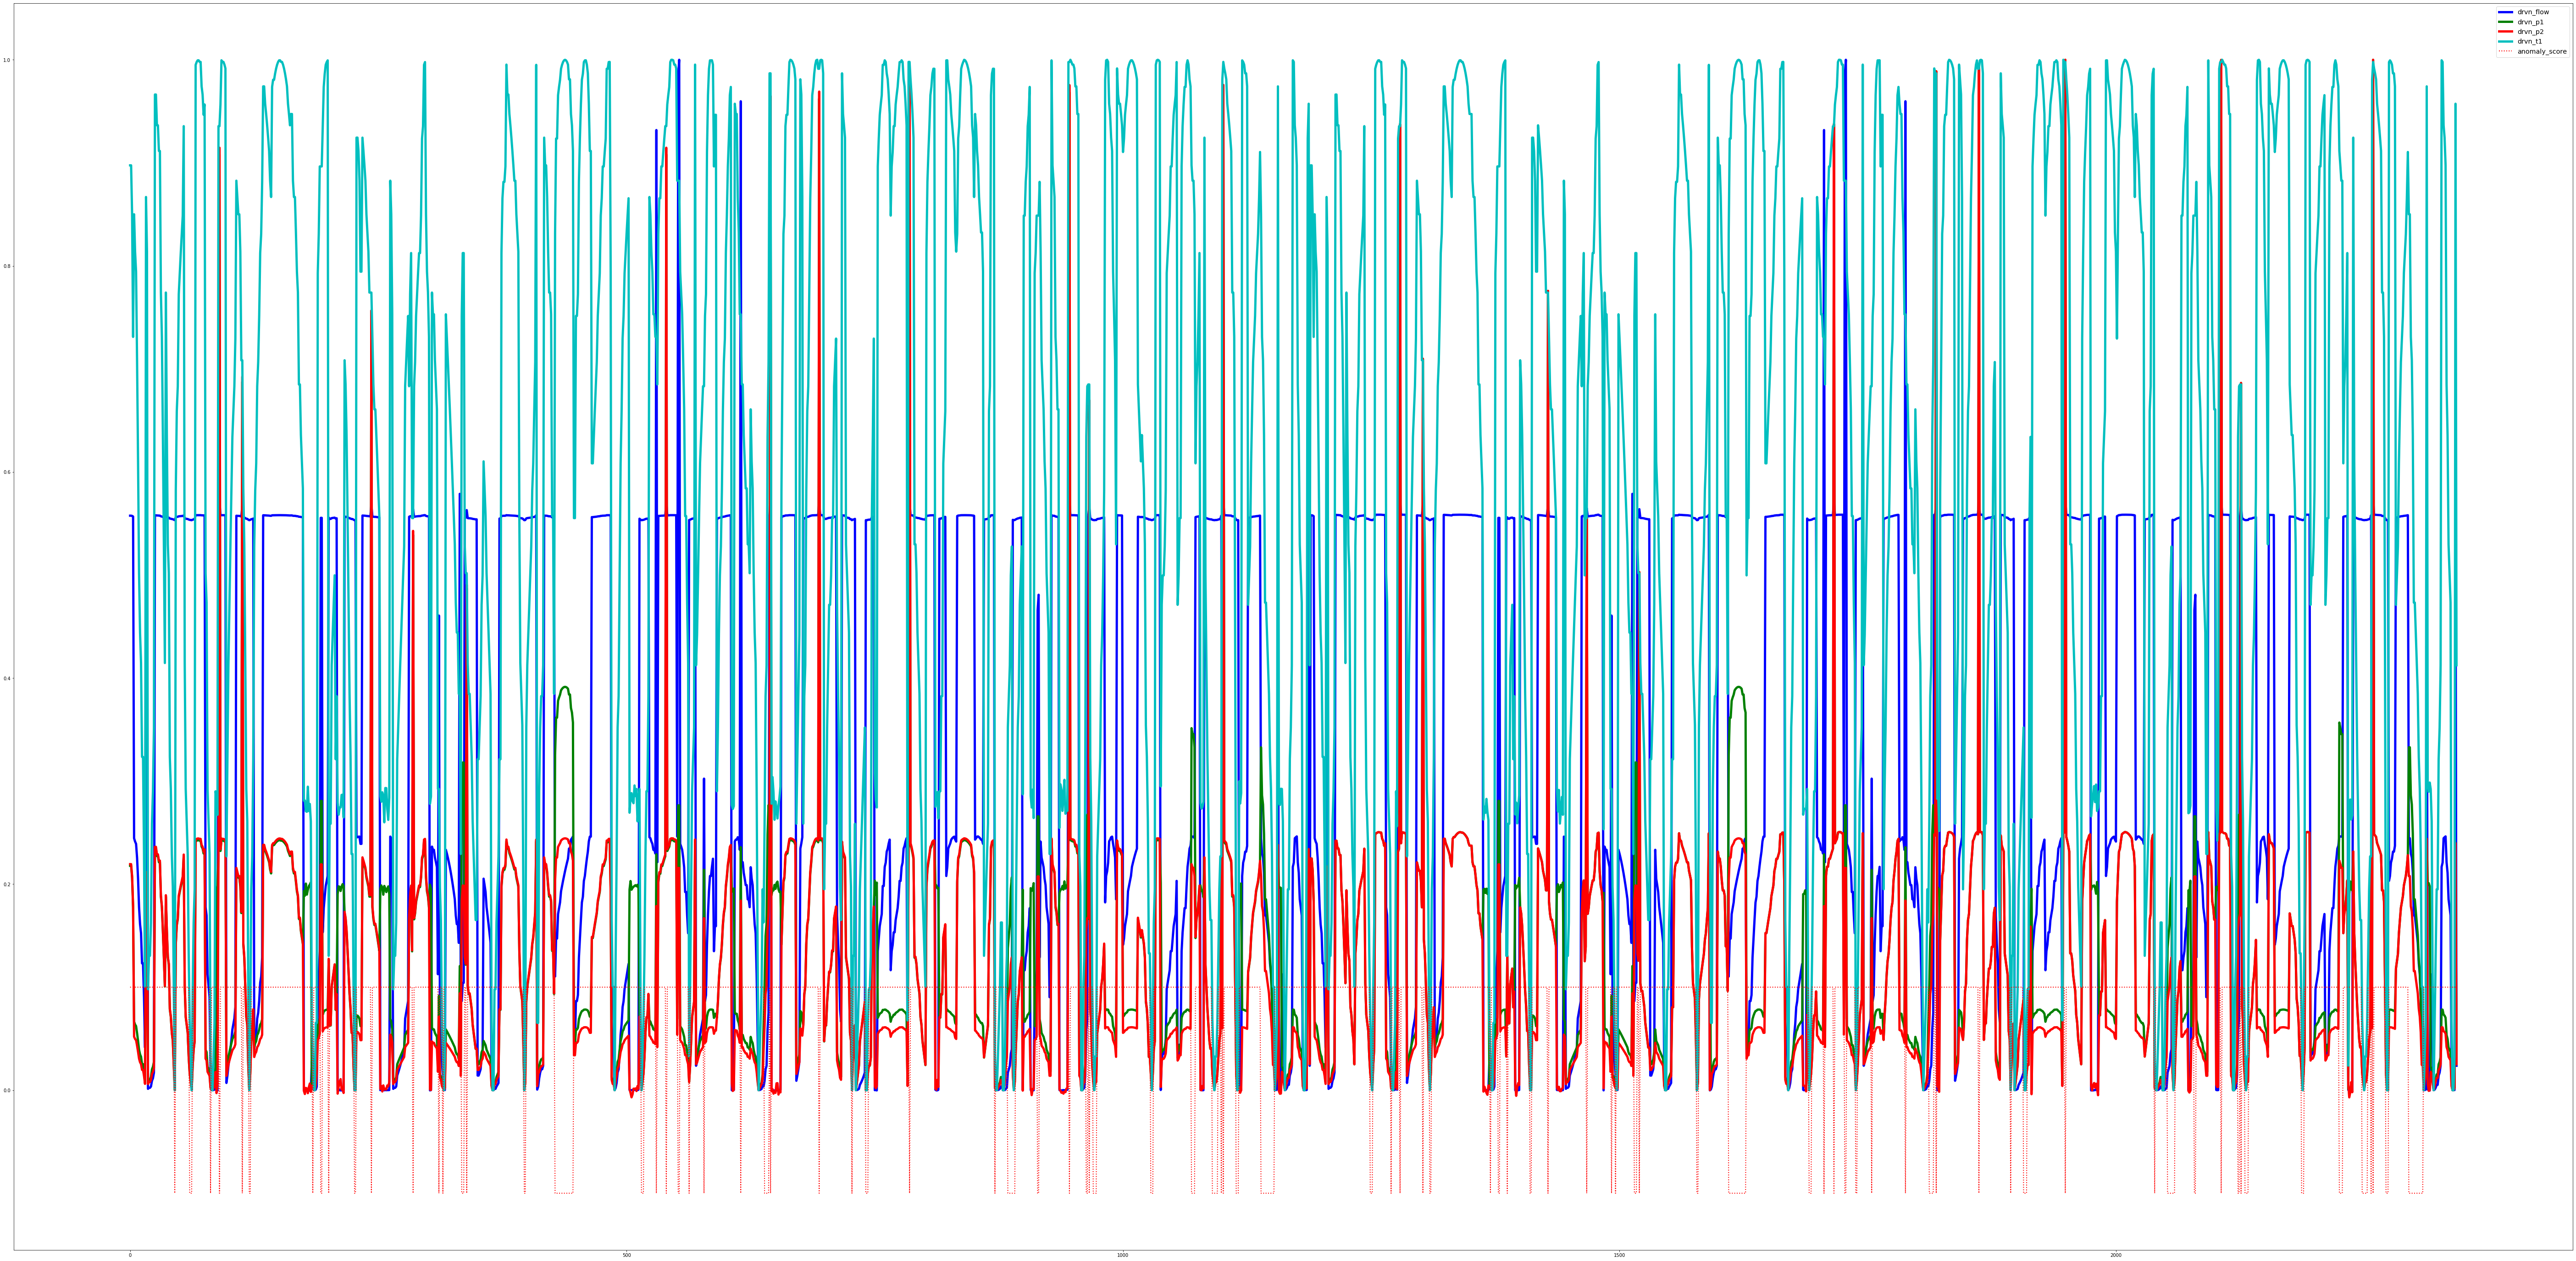

In [74]:
# PLOT RESULTS
# note - devices 73002 73003 are normal. 73001, 73000 have more anomalies

import matplotlib.pyplot as plt
plt.figure(figsize=(100, 50))

colors = "bgcmykwr"
for idx in range(0, (len(columns) - 1)):
    m = max(s_df[columns[idx]])
    # normalize values to make graph easier to read
    values = s_df[columns[idx]] / m
    plt.plot(values, color=colors[idx], label=columns[idx], linewidth=5)
    
plt.plot(s_df['anomaly_score'] * .1, color='red', label='anomaly_score', linestyle="dotted", linewidth=2)
plt.legend(columns + ['anomaly_score'])
plt.legend(fontsize="x-large")
plt.savefig('/tmp/plotout.png')


# Publish Model

In [4]:
! pip3 install ibm_watson_machine_learning --user

     |████████████████████████████████| 1.4 MB 1.2 MB/s eta 0:00:01
  Using cached pandas-0.25.3-cp37-cp37m-macosx_10_9_x86_64.whl (10.2 MB)
Processing /Users/kkbankol@us.ibm.com/Library/Caches/pip/wheels/37/9c/c4/a2c610ccb877d37c2cb87a5bfe55845fecffd6bb01bcd5e9d5/ibm_cos_sdk-2.6.0-py2.py3-none-any.whl
ERROR: iotfunctions 2.0.3 has requirement ibm-cos-sdk==2.1.3, but you'll have ibm-cos-sdk 2.6.0 which is incompatible.


----  ----------  ----  --------
NAME  ASSET_TYPE  SIZE  ASSET_ID
----  ----------  ----  --------


In [75]:
# PUBLISH MODEL TO WML
from ibm_watson_machine_learning import APIClient
import json

# USER PREREQ # Update path to WML credentials #
if 'WML_CREDENTIALS_PATH' in os.environ.keys():
    wml_creds_path = os.environ['WML_CREDENTIALS_PATH']
else:
    wml_creds_path = './credentials/wml_credentials.json'

with open(wml_creds_path) as F:
    wml_credentials = json.loads(F.read())
    
client = APIClient(wml_credentials)

if 'project_id' in wml_credentials.keys():
    client.set.default_project(wml_credentials['project_id'])    
if 'space_id' in wml_credentials.keys():
    client.set.default_space(wml_credentials['space_id'])

client.data_assets.list()

# Create WML client
# from ibm_watson_machine_learning import APIClient
# wml_credentials = json.loads(open(wml_creds_path).read())
# client = APIClient(wml_credentials)
#client = WatsonMachineLearningAPIClient( wml_credentials )

# TODO, default space has to be added
# client.set.default_space()

# Define ML framework (sklearn, keras, etc)
sk_version = sklearn.__version__
metadata = {
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: 'scikit-learn',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: sk_version,
    client.repository.ModelMetaNames.NAME: 'anomaly_model',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6'
}

# Upload trained model pipeline to WML
model_details_inmem = client.repository.store_model( pipeline, meta_props=metadata)
model_id_inmem = model_details_inmem["metadata"]["guid"]
deployment_details_inmem = client.deployments.create( artifact_uid=model_id_inmem, name="anomaly_model" )
deployment_id = deployment_details_inmem["metadata"]["guid"]
model_endpoint_url_inmem = client.deployments.get_scoring_url( deployment_details_inmem )
print("model invocation endpoint: " + model_endpoint_url_inmem)
print("Place below line in .env file like so")

### IMPORTANT, once this is done, take note of the WATSON_ML_DEPLOYMENT_ID
print("WATSON_ML_DEPLOYMENT_ID=" + deployment_id) # TODO, need to confirm notebook will reload .env file. Or just change from .env to mem





2020-06-01 14:15:44,763 - ModelCollection - DEBUG - 
Creating a new scikit pipeline model: anomaly_model

2020-06-01 14:15:46,950 - watson_machine_learning_client.libs.repo.swagger_client.rest - DEBUG - 
response body: {"metadata":{"guid":"864afe38-35ae-465e-9c6d-a9aabdb0643d","url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/864afe38-35ae-465e-9c6d-a9aabdb0643d","created_at":"2020-06-01T21:15:45.788Z"},"entity":{"name":"anomaly_model","model_url":"/v3/ml_assets/models/864afe38-35ae-465e-9c6d-a9aabdb0643d","framework":{"name":"scikit-learn","version":"0.20","runtimes":[{"name":"python","version":"3.6"}]},"model_version":{"url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/864afe38-35ae-465e-9c6d-a9aabdb0643d/versions/fac90616-fafc-4c93-9006-dd3ec8945a6a","guid":"fac90616-fafc-4c93-9006-dd3ec8945a6a","content_status":{"state":"no_content"},"hyper_parameters":[],"content_url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/864afe38-35ae-465e-9c6d-a9aabdb0643d/



#######################################################################################

Synchronous deployment creation for uid: '864afe38-35ae-465e-9c6d-a9aabdb0643d' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4ec668fb-a387-46fb-abb2-1b73479303e4'
------------------------------------------------------------------------------------------------


model invocation endpoint: https://us-south.ml.cloud.ibm.com/v3/wml_instances/96665647-9805-45e0-baec-e6484dc74628/deployments/4ec668fb-a387-46fb-abb2-1b73479303e4/online
Place below line in .env file like so
WATSON_ML_DEPLOYMENT_ID=4ec668fb-a387-46fb-abb2-1b73479303e4


In [76]:
# Print deployments
client.deployments.list()

------------------------------------  ---------------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME                   TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
4ec668fb-a387-46fb-abb2-1b73479303e4  anomaly_model          online  DEPLOY_SUCCESS  2020-06-01T21:15:50.139Z  scikit-learn-0.20  model
509e3084-8591-4894-b62a-5c2baf782a87  anomaly_model          online  DEPLOY_SUCCESS  2020-06-01T06:39:37.583Z  scikit-learn-0.20  model
1220d86c-c8d0-46cc-b14e-ae5ac43c5eb1  GermanCreditRiskModel  online  DEPLOY_SUCCESS  2020-05-06T18:03:13.238Z  mllib-2.3          model
c4f31a07-9d81-4f55-b58a-6e9aa2f81326  anomaly_model          online  DEPLOY_SUCCESS  2020-05-06T17:07:51.816Z  scikit-learn-0.20  model
e27d7be5-3c35-4ccd-bee6-f9dfdb5d9407  anomaly_model          online  DEPLOY_SUCCESS  2020-05-06T17:07:07.281Z  scikit-learn-0.20  model
fa9e74dc-fb94-4423-8c9d-480292aa

In [77]:
# Publish function to Maximo Monitor

from custom.functions import InvokeWMLModel
db.register_functions([InvokeWMLModel], force_preinstall=True)


2020-06-01 14:16:29,489 - iotfunctions.db - DEBUG - 
<module 'custom.functions' from '/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/custom/functions.py'> is preinstalled False

2020-06-01 14:16:29,497 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'input_items', 'type': 'DATA_ITEM', 'dataType': 'ARRAY', 'dataTypeForArray': ['NUMBER'], 'required': True, 'description': 'Data items adjust', 'tags': [], 'jsonSchema': {'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'array', 'minItems': 1, 'maxItems': None, 'items': {'type': 'string'}}}

2020-06-01 14:16:29,498 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'wml_endpoint', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Endpoint to WML service where model is hosted', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-06-01 14:16:29,499 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'instance_id', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'd

''

In [84]:
# Invoke function in monitor
WATSON_ML_ENDPOINT = wml_credentials['url']
WATSON_ML_INSTANCE_ID = wml_credentials['instance_id']
WATSON_ML_APIKEY = wml_credentials['apikey']
WATSON_ML_DEPLOYMENT_ID=deployment_id

entity = EntityType(
                entity_name, 
                db,
                InvokeWMLModel(
                                wml_endpoint=WATSON_ML_ENDPOINT,
                                instance_id=WATSON_ML_INSTANCE_ID,
                                deployment_id=WATSON_ML_DEPLOYMENT_ID,
                                apikey=WATSON_ML_APIKEY,
                                input_items=columns
                ),
                **{
                  '_timestamp' : 'evt_timestamp',
                  '_db_schema' : db_schema}
)
entity.exec_local_pipeline()



2020-06-01 14:18:07,566 - root - DEBUG - 
Initializing

2020-06-01 14:18:07,567 - root - DEBUG - 
sorted input_items ['drvn_flow', 'drvn_p1', 'drvn_p2', 'drvn_t1', 'drvn_t2']

2020-06-01 14:18:07,569 - iotfunctions.metadata - DEBUG - 
Initializing new entity type using iotfunctions 2.0.3

2020-06-01 14:18:07,570 - iotfunctions.util - DEBUG - 
Starting trace

2020-06-01 14:18:07,578 - iotfunctions.util - DEBUG - 
Trace name: auto_trace_turbine_demo_20200601211807

2020-06-01 14:18:07,579 - iotfunctions.util - DEBUG - 
auto_save None

2020-06-01 14:18:07,580 - iotfunctions.metadata - WARNING - 
No _db_schema specified in **kwargs. Usingdefault database schema.

2020-06-01 14:18:07,580 - iotfunctions.metadata - WARNING - 
No _db_schema specified in **kwargs. Usingdefault database schema.

2020-06-01 14:18:07,583 - iotfunctions.util - DEBUG - 
categorizing arguments
/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sqlalchemy/engine/reflection.


2020-06-01 14:18:08,891 - iotfunctions.pipeline - INFO - 
Trimmed data source read_entity_data down to columns ['drvn_t1', 'drvn_p2', 'drvn_t2', 'drvn_flow', 'deviceid', 'drvn_p1', 'evt_timestamp'] as remaining columns {'unscheduled_maintenance', 'run_status_x', 'asset_id', 'drvr_rpm', 'mainteancne_status_y', 'run_status', 'predict_drvn_t1', 'predict_drvn_t2', 'scheduled_maintenance', 'compressor_out_x', 'compressor_out_y', 'run_status_y', 'predict_drvn_p1', 'maintenance_status_x', 'compressor_in_x', 'predict_drvn_p2', 'compressor_in_y'} are not used

2020-06-01 14:18:08,891 - iotfunctions.pipeline - INFO - 
Trimmed data source read_entity_data down to columns ['drvn_t1', 'drvn_p2', 'drvn_t2', 'drvn_flow', 'deviceid', 'drvn_p1', 'evt_timestamp'] as remaining columns {'unscheduled_maintenance', 'run_status_x', 'asset_id', 'drvr_rpm', 'mainteancne_status_y', 'run_status', 'predict_drvn_t1', 'predict_drvn_t2', 'scheduled_maintenance', 'compressor_out_x', 'compressor_out_y', 'run_status_y

TBD ***** - Add stages for usage stats



2020-06-01 14:18:10,263 - iotfunctions.metadata - DEBUG - 
Indexed dataframe on id, evt_timestamp

2020-06-01 14:18:10,268 - iotfunctions.pipeline - DEBUG - 
No method get_column_map on read_entity_data returning default None. 'DataReader' object has no attribute 'get_column_map'

2020-06-01 14:18:10,269 - iotfunctions.system_function - DEBUG - 
Merging dataframe with columns [] and index []

2020-06-01 14:18:10,271 - iotfunctions.metadata - DEBUG - 
Found existing index on id, evt_timestamp.No need to recreate index

2020-06-01 14:18:10,275 - iotfunctions.pipeline - INFO - 
Trace message:  Completed stage.

2020-06-01 14:18:10,275 - iotfunctions.pipeline - INFO - 
Trace message:  Completed stage.

2020-06-01 14:18:10,277 - iotfunctions.pipeline - INFO - 
Trace payload: {'produces_output_items': True, 'output_items': ['drvn_t1', 'drvn_p2', 'drvn_t2', 'drvn_flow', 'deviceid', 'drvn_p1', 'evt_timestamp'], 'discard_prior_data': False, 'merge_result': 'existing empty df with new DataFrame


2020-06-01 14:18:13,045 - root - DEBUG - 
json

2020-06-01 14:18:13,046 - root - DEBUG - 
{'fields': ['prediction'], 'values': [[-1], [-1], [1], [1], [1], [-1], [-1], [1], [1], [1], [-1], [-1], [1], [1], [1], [1], [-1], [1], [1], [-1], [-1], [-1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [-1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [-1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [-1], [-1], [-1], [1], [1], [-1], [-1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [


2020-06-01 14:18:13,054 - root - DEBUG - 
setting to 0

2020-06-01 14:18:13,057 - root - DEBUG - 
results received

2020-06-01 14:18:13,060 - root - DEBUG - 
int64

2020-06-01 14:18:13,062 - iotfunctions.system_function - DEBUG - 
Input dataframe has columns ['drvn_t1', 'drvn_p2', 'drvn_t2', 'drvn_flow', 'deviceid', 'drvn_p1', '_timestamp'] and index ['id', 'evt_timestamp']

2020-06-01 14:18:13,063 - iotfunctions.system_function - DEBUG - 
Merging dataframe with columns ['drvn_t1', 'drvn_p2', 'drvn_t2', 'drvn_flow', 'deviceid', 'drvn_p1', '_timestamp'] and index ['id', 'evt_timestamp']

2020-06-01 14:18:13,065 - iotfunctions.system_function - DEBUG - 
Merging dataframe with the same index

2020-06-01 14:18:13,072 - iotfunctions.pipeline - INFO - 
Trace message:  Completed stage.

2020-06-01 14:18:13,072 - iotfunctions.pipeline - INFO - 
Trace message:  Completed stage.

2020-06-01 14:18:13,074 - iotfunctions.pipeline - INFO - 
Trace payload: {'produces_output_items': True, 'output_ite


2020-06-01 14:18:13,168 - iotfunctions.pipeline - WARNING - 
Traceback (most recent call last):
  File "/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/l

ConnectionError: HTTPSConnectionPool(host='undefined', port=443): Max retries exceeded with url: /analytics-runtime-monitor-demo-395729cb6a06/Monitor-Demo/turbine_demo/20200601/turbine_demo_trace_211808 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x12fb9f750>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))